# 範例目標:
推導 優化器: Adam, 了解其原理與優化過程

# 範例重點:

提供 AdamOptimizer 的範例, 可以讓學員驗證 m, v 與 β 的變化關係


# 以下的片段範例需要有 ffmpeg

請務必使用 conda 指令安裝

務必確認 HDD 有足夠的空間

>conda install -c conda-forge ffmpeg

> NOTE: 必須在執行此一範例前先行安裝

In [1]:
import sys
print(sys.version)

In [2]:
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad,value_and_grad,grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest

# Objective function: the Beale function

In [3]:
# Objective function: the Beale function

f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

z = f(x, y)
minima = np.array([3., .5])
f(*minima)

0.0

In [4]:
minima_ = minima.reshape(-1, 1)
minima_

f(*minima_)

array([0.])

In [5]:
def target_func(weights):
    x,y = weights
    return f(x,y)

# Adam Optimizer

In [6]:
class Adam:
    def __init__(self, loss, weights, lr=0.001, beta1=0.9, beta2=0.999, epislon=1e-8):
        self.loss = loss
        self.theta = weights
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epislon = epislon
        self.get_gradient = grad(loss)
        self.m = 0
        self.v = 0
        self.t = 0

    def minimize_raw(self):
        self.t += 1
        g = self.get_gradient(self.theta)
        self.m = self.beta1 * self.m + (1 - self.beta1) * g
        self.v = self.beta2 * self.v + (1 - self.beta2) * (g * g)
        self.m_hat = self.m / (1 - self.beta1 ** self.t)
        self.v_hat = self.v / (1 - self.beta2 ** self.t)
        self.theta -= self.lr * self.m_cat / (self.v_cat ** 0.5 + self.epislon)

    def minimize(self):
        self.t += 1
        g = self.get_gradient(self.theta)
        lr = self.lr * (1 - self.beta2 ** self.t) ** 0.5 / (1 - self.beta1 ** self.t)
        self.m = self.beta1 * self.m + (1 - self.beta1) * g
        self.v = self.beta2 * self.v + (1 - self.beta2) * (g * g)
        self.theta -= lr * self.m / (self.v ** 0.5 + self.epislon)

    def minimize_trace(self, path=[]):
        self.t += 1
        g = self.get_gradient(self.theta)
        lr = self.lr * (1 - self.beta2 ** self.t) ** 0.5 / (1 - self.beta1 ** self.t)
        self.m = self.beta1 * self.m + (1 - self.beta1) * g
        self.v = self.beta2 * self.v + (1 - self.beta2) * (g * g)
        self.theta -= lr * self.m / (self.v ** 0.5 + self.epislon)
        path.append(np.copy(self.theta))

In [7]:
EPOCHS = 3000
SHOW_STEPS = 100
PRECISION = 1e-8
weights = np.array([1., 1.5])
path_trace = [np.copy(weights)]
adam = Adam(target_func, weights, lr=0.01)
print(f"start to optimize EPOCHS: {EPOCHS}")
progress_step = EPOCHS // SHOW_STEPS

for i in range(EPOCHS):
    if i % progress_step == 0:
        loss_value = adam.loss(adam.theta)
        print(f"times:{i:4d}\tweights:[{adam.theta[0]:.3f}, {adam.theta[1]:.3f}]\tloss:{loss_value:.6f}")
        if loss_value < PRECISION:
            print(f"loss:{loss_value:.6f} is less than precision:{PRECISION}, finish!")
            break
    adam.minimize_trace(path_trace)
print(f"\nfinal weights:[{adam.theta[0]:.3f}, {adam.theta[1]:.3f}] loss:{adam.loss(adam.theta):.6f}")

start to optimize EPOCHS: 3000
times:   0	weights:[1.000, 1.500]	loss:41.250000
times:  30	weights:[0.737, 1.229]	loss:20.299015
times:  60	weights:[0.606, 1.048]	loss:15.060863
times:  90	weights:[0.586, 0.918]	loss:12.981398
times: 120	weights:[0.650, 0.805]	loss:11.321904
times: 150	weights:[0.781, 0.694]	loss:9.427609
times: 180	weights:[0.959, 0.585]	loss:7.290086
times: 210	weights:[1.160, 0.483]	loss:5.207436
times: 240	weights:[1.361, 0.393]	loss:3.479711
times: 270	weights:[1.546, 0.321]	loss:2.228036
times: 300	weights:[1.706, 0.267]	loss:1.411090
times: 330	weights:[1.840, 0.230]	loss:0.917347
times: 360	weights:[1.948, 0.207]	loss:0.633483
times: 390	weights:[2.034, 0.196]	loss:0.472804
times: 420	weights:[2.102, 0.194]	loss:0.378914
times: 450	weights:[2.157, 0.198]	loss:0.319253
times: 480	weights:[2.202, 0.207]	loss:0.276805
times: 510	weights:[2.240, 0.218]	loss:0.243404
times: 540	weights:[2.274, 0.231]	loss:0.215377
times: 570	weights:[2.304, 0.244]	loss:0.191109
time

In [8]:
path_trace = np.array(path_trace).T
shape = path_trace.shape
if shape[1] > SHOW_STEPS:
    show_step = shape[1] // SHOW_STEPS
    path_trace = np.array(path_trace[:,::show_step])
# print(path_trace)

# Visualize Convergence Trace

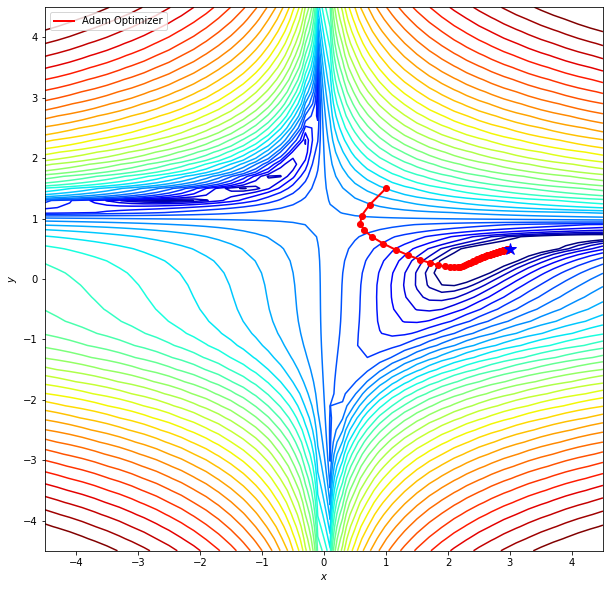

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)

line, = ax.plot(path_trace[0, :], path_trace[1, :], 'r', label='Adam Optimizer', lw=2)
point, = ax.plot(path_trace[0, :], path_trace[1, :], 'ro')

ax.plot(*minima_, 'b*', markersize=12)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.legend(loc='upper left')

plt.show()

In [10]:
import matplotlib.animation as manimation
manimation.writers.list()

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def animate(i):
    line.set_data(*path_trace[::,:i])
    point.set_data(*path_trace[::,i-1:i])
    return line, point

# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=path_trace.shape[1], interval=60, 
#                                repeat_delay=5, blit=True)
# HTML(anim.to_html5_video())